In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
TOP_FEATURES = [
    "path_count_upper",
    "url_len",
    "url_entropy",
    "url_has_login",
    "path_count_no_of_dir",
    "url_count_sensitive_financial_words",
    "subdomain_len",
    "path_len",
    "url_count_digit",
    "url_count_sensitive_words"
]


In [3]:
def shannon_entropy(s):
    if len(s) == 0:
        return 0
    probs = [s.count(c) / len(s) for c in set(s)]
    return -sum(p * math.log2(p) for p in probs)

def extract_features_from_url(url):
    try:
        if not url.startswith(("http://", "https://")):
            url = "http://" + url

        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        path = parsed.path or ""
        url_lower = url.lower()

        # Keywords
        financial_words = ["bank", "paypal", "credit", "account", "finance"]
        sensitive_words = [
            "login", "signin", "secure", "verify", "confirm",
            "account", "update", "password", "admin"
        ]

        # Subdomain extraction (simple & fast)
        parts = domain.split(".")
        subdomain = ".".join(parts[:-2]) if len(parts) > 2 else ""

        features = {
            "path_count_upper": sum(c.isupper() for c in path),
            "url_len": len(url),
            "url_entropy": shannon_entropy(url),
            "url_has_login": int("login" in url_lower),
            "path_count_no_of_dir": len([p for p in path.split("/") if p]),
            "url_count_sensitive_financial_words": sum(url_lower.count(w) for w in financial_words),
            "subdomain_len": len(subdomain),
            "path_len": len(path),
            "url_count_digit": sum(c.isdigit() for c in url),
            "url_count_sensitive_words": sum(url_lower.count(w) for w in sensitive_words)
        }

        return np.array([features[f] for f in TOP_FEATURES], dtype=float)

    except Exception:
        # Safe fallback — never crash demo
        return np.zeros(len(TOP_FEATURES))


In [4]:
df = pd.read_csv("test_dataset.csv")

X = df[TOP_FEATURES].values
y = df["label"].values  # 1 = malicious, 0 = benign

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(
    max_iter=300,
    class_weight="balanced",
    n_jobs=1
)
model.fit(X_train_scaled, y_train)

print("Model trained ✔")


Model trained ✔


In [5]:
def predict_url_risk(url):
    features = extract_features_from_url(url)
    features_scaled = scaler.transform([features])

    prob = model.predict_proba(features_scaled)[0, 1]
    return prob, features


In [6]:
def plot_feature_contributions(url):
    prob, features = predict_url_risk(url)

    contributions = model.coef_[0] * features
    contrib_df = pd.DataFrame({
        "Feature": TOP_FEATURES,
        "Contribution": contributions
    }).sort_values(by="Contribution")

    plt.figure(figsize=(8, 5))
    colors = ["red" if v > 0 else "blue" for v in contrib_df["Contribution"]]

    plt.barh(contrib_df["Feature"], contrib_df["Contribution"], color=colors)
    plt.axvline(0, color="black", linewidth=1)
    plt.title(f"Feature Contributions\nRisk Score: {prob*100:.1f}%")
    plt.xlabel("Contribution toward Malicious")
    plt.tight_layout()
    plt.show()


URL: usa.gov
Malicious Risk Score: 21.8%


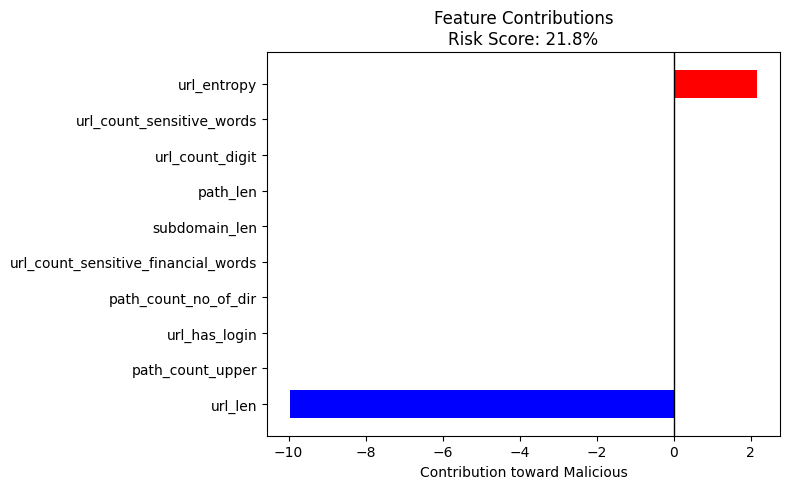

In [10]:
test_url = "walmart.vcom"

risk, _ = predict_url_risk(test_url)

print(f"URL: {test_url}")
print(f"Malicious Risk Score: {risk*100:.1f}%")

plot_feature_contributions(test_url)
